# Modelling using value of R0

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [2448]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn import tree
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree

from sklearn.metrics import fbeta_score, make_scorer
import seaborn as sns
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
import shap

import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Read file and prepare data 

In [2449]:
#df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL.csv')
del df['Unnamed: 0']
del df['Excess mortality P-scores, all ages']
del df['Excess mortality P-scores, all ages Prev 7 days']
del df['Excess mortality P-scores, all ages Prev 36 days']
del df['deaths']
del df['deaths_prev_7']
del df['deaths_prev_18']
del df['deaths_prev_36']
del df['average_deaths_2015_2019_all_ages']
del df['month']
del df['life_expectancy']
del df['UN Population Division (Median Age) (2017)']

In [2450]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,%df_population_gr_65,"Excess mortality P-scores, all ages Prev 18 days",accumulated,R0
0,AUS,2020-03-08,1.050000,1.722333,-0.739000,4.977667,-2.089000,7.927667,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,15.921202,6.18,0.000762,0.949187
1,AUS,2020-03-15,0.761714,1.510143,-1.286000,7.697286,-0.819857,10.567714,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,15.921202,4.53,0.001320,0.989293
2,AUS,2020-03-22,1.285714,3.367429,-1.081714,9.346857,0.938857,10.877857,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,15.921202,4.92,0.001926,1.575758
3,AUS,2020-03-29,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,15.921202,4.67,0.002502,1.666209
4,AUS,2020-04-05,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,15.921202,4.62,0.002969,0.932399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.693857,-4.061286,10.183857,-36.040857,-19.755143,-28.101857,1.0,3.0,...,11.89,2.87,75608000.0,82.058,0.216667,8.30,16.209606,41.25,0.179232,0.821006
2038,USA,2021-01-17,-22.775429,-3.979571,12.653143,-38.877714,-16.653143,-42.081714,1.0,3.0,...,11.89,2.87,75608000.0,82.058,0.686667,8.30,16.209606,41.07,0.188522,0.922972
2039,USA,2021-01-24,-23.632714,-9.836714,14.061286,-41.020286,-15.857143,-41.714143,1.0,3.0,...,11.89,2.87,75608000.0,82.058,1.415000,8.30,16.209606,44.75,0.198645,0.870835
2040,USA,2021-01-31,-23.979714,-11.387857,11.449143,-39.571429,-22.591714,-28.999857,1.0,3.0,...,11.89,2.87,75608000.0,82.058,2.464000,8.30,16.209606,36.74,0.206956,0.830681


In [2451]:
df['bad_mobility']=(df['retail_and_recreation']*0.4+df['transit_stations']*0.2+df['grocery_and_pharmacy']*0.2
                   +df['workplaces']*0.2)
del df['retail_and_recreation']
del df['grocery_and_pharmacy']
del df['transit_stations']
del df['workplaces']

df['good_mobility']=(df['residential']*0.6+df['parks']*0.4)
del df['residential']
del df['parks']

df['tourism']=df['number_of_arrivals']/df['international_travel_controls']
df['awareness'] = df['public_information_campaigns']*0.2+df['facial_coverings']*0.8
df['work_life_closures']=df['workplace_closures']*0.7+df['school_closures']*0.3
df['government_support']=df['debt_relief']*0.5+df['income_support']*0.5
df['%df_population_gr_65']=df['%df_population_gr_65']-(df['accumulated']*df['%df_population_gr_65']/100)
df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['hospital_availability']=df['nurses_per_1000']*0.2+df['doctors_per_1000']*0.2+df['beds_per_1000']*0.6
df['youth_effect']=df['%youth_unemployment_total']*df['bad_mobility']

del df['contact_tracing']
del df['testing_policy']
del df['international_travel_controls']
del df['number_of_arrivals']
del df['public_information_campaigns']
del df['facial_coverings']
del df['workplace_closures']
del df['school_closures']
del df['debt_relief']
del df['income_support']
del df['doctors_per_1000']
del df['beds_per_1000']
del df['nurses_per_1000']
del df['%youth_unemployment_total']
del df['urban_population']
del df['%df_population_gr_65']

df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]

In [2452]:
#df=df[(df['Excess mortality P-scores, all ages Prev 18 days']>1)]
df=df[~df.isin([np.inf, -np.inf]).any(1)]
df=df[(np.abs(df['R0'])<3.4)]
df=df[df['R0']>0]
df.columns

Index(['Code', 'Date', 'restrictions_internal_movements',
       'close_public_transport', 'stay_home_requirements',
       'restriction_gatherings', 'cancel_public_events', 'Holiday', 'temp',
       'prcp', 'total_vaccinations_per_100',
       'Excess mortality P-scores, all ages Prev 18 days', 'accumulated',
       'bad_mobility', 'good_mobility', 'tourism', 'awareness',
       'work_life_closures', 'government_support', 'hospital_availability',
       'youth_effect', 'R0'],
      dtype='object')

In [2453]:
df.sort_values('R0')

,Code,Date,restrictions_internal_movements,close_public_transport,stay_home_requirements,restriction_gatherings,cancel_public_events,Holiday,temp,prcp,...,accumulated,bad_mobility,good_mobility,tourism,awareness,work_life_closures,government_support,hospital_availability,youth_effect,R0
204,BGR,2021-02-14,0.0,0.000000,0.0,3.000000,2.000000,0.0,3.690625,0.086937,...,0.350230,-30.199914,-0.881714,2.750667e+06,2.800000,2.000000,1.5,NaN,-268.477248,0.014184
1821,SVK,2020-08-16,1.0,0.571429,0.0,2.000000,0.000000,0.0,18.579259,0.091133,...,0.007928,-5.102000,60.448943,1.013500e+06,2.800000,0.600000,2.0,5.26400,-82.193223,0.022010
1801,SVK,2020-03-29,0.0,0.000000,0.0,0.000000,1.142857,0.0,2.817943,0.064054,...,0.000000,0.599971,2.828543,2.364833e+06,0.400000,0.171429,0.0,5.26400,9.665540,0.025176
1566,NOR,2020-09-27,1.0,0.000000,0.0,3.000000,0.000000,1.0,10.584378,0.091880,...,0.008865,-8.869486,33.902029,2.980000e+06,1.200000,1.000000,1.0,6.65200,-87.630520,0.030856
1475,MLT,2021-01-17,0.0,0.000000,0.0,4.000000,2.000000,0.0,NaN,NaN,...,0.128624,-16.191743,6.742743,6.553333e+05,3.600000,1.700000,1.5,NaN,-148.316362,0.032086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,LVA,2020-10-11,0.0,0.000000,1.0,1.428571,0.000000,0.0,13.071181,0.000000,...,0.027899,-2.391800,30.693886,8.965000e+05,1.542857,2.042857,1.0,4.82400,-29.849663,3.237113
262,CHE,2020-05-31,1.0,0.000000,1.0,4.000000,2.000000,0.0,11.833333,0.096231,...,0.026109,-36.941514,19.461171,3.068333e+06,1.200000,1.914286,1.5,7.16400,-294.793285,3.274648
565,ECU,2020-03-22,0.0,0.000000,0.0,0.000000,0.000000,0.0,22.406810,0.148629,...,0.001609,-7.763343,1.351057,3.308667e+06,0.200000,0.000000,0.0,NaN,-67.618717,3.354331
1024,HRV,2021-02-21,0.0,0.000000,0.0,4.000000,1.000000,0.0,4.937654,0.168556,...,0.191587,-33.008229,2.836743,4.603000e+06,2.800000,1.700000,1.0,NaN,-548.596787,3.366412


df=df[['Code', 'Date', 'retail_and_recreation','restriction_gatherings', 'urban_population', 'workplace_closures', 'temp', 'accumulated', 'R0' ]]

df['R0_dummy_pred']=(df['R0_prev18']- (df['accumulated']*df['R0_prev18']/100))**2
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
del df['R0_prev18']

## Feature Engineering

df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)

df['movement']=df['number_of_arrivals']/((df['international_travel_controls']+df['restrictions_internal_movements'])/2)
del df['international_travel_controls']
del df['restrictions_internal_movements']
del df['number_of_arrivals']
df['tracking']=(df['testing_policy']+df['contact_tracing'])/2
del df['testing_policy']
del df['contact_tracing']
df['economic_support']=(df['debt_relief']+df['income_support'])/2
del df['debt_relief']
del df['income_support']
df['%youth_unemployment_total']=df['%youth_unemployment_total']*df['retail_and_recreation']
#df['days_from_beginning']= (pd.to_datetime(df['Date']) -pd.Timestamp(2020, 3, 1)).dt.days
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
df

In [2454]:
df.columns

Index(['Code', 'Date', 'restrictions_internal_movements',
       'close_public_transport', 'stay_home_requirements',
       'restriction_gatherings', 'cancel_public_events', 'Holiday', 'temp',
       'prcp', 'total_vaccinations_per_100',
       'Excess mortality P-scores, all ages Prev 18 days', 'accumulated',
       'bad_mobility', 'good_mobility', 'tourism', 'awareness',
       'work_life_closures', 'government_support', 'hospital_availability',
       'youth_effect', 'R0'],
      dtype='object')

In [2455]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

date1=pd.Timestamp(2020, 3, 1)
df['mobility']=(df['retail_and_recreation']*0.5+df['transit_stations']*0.3 +df['workplaces']*0.3)
del df['retail_and_recreation']
del df['grocery_and_pharmacy']
del df['residential']
del df['transit_stations']
del df['workplaces']
del df['parks']
del df['mobility']
#df['days_from_beginning']=(pd.to_datetime(df['Date'])-date1).dt.days
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]

## PCA

In [2456]:
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['accumulated'] = df['accumulated'].fillna(0)
df['urban_population'] = df['urban_population'].fillna(df['urban_population'].mean())
df['parks'] = df['parks'].fillna(df['parks'].mean())
df['temp'] = df['temp'].fillna(df['temp'].mean())
df['prcp'] = df['prcp'].fillna(df['prcp'].mean())
df['%youth_unemployment_total'] = df['%youth_unemployment_total'].fillna(df['%youth_unemployment_total'].mean())
#df['life_expectancy'] = df['life_expectancy'].fillna(df['life_expectancy'].mean())
df['%df_population_gr_65'] = df['%df_population_gr_65'].fillna(df['%df_population_gr_65'].mean())
#df['%df_population_gr_65']=df['%df_population_gr_65'].fillna(df['%df_population_gr_65'].mean())
#df['R0_dummy_pred']=df['R0_dummy_pred'].fillna(df['R0_dummy_pred'].mean())
#df= df[df.columns[2:-1]].dropna()

KeyError: 'urban_population'

In [ ]:
df.isna().sum()

In [ ]:
df.columns

In [2457]:
from sklearn.preprocessing import StandardScaler

features=['retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total','%df_population_gr_65',
       'Excess mortality P-scores, all ages Prev 18 days','accumulated']

# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['R0']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

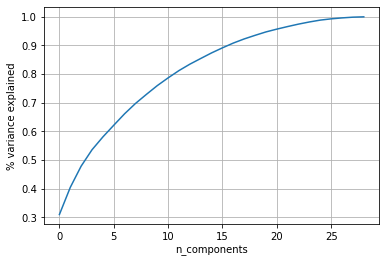

In [2458]:
from sklearn.decomposition import PCA
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [2459]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(x)

In [2460]:
principalComponents.size

23205

In [2461]:
principalDf = pd.DataFrame(data = principalComponents)

In [2462]:
principalDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-5.738009,1.759953,-0.698890,-1.608423,1.446390,1.482554,0.696642,-0.913105,-0.716434,-0.577872,0.656501,1.075282,0.688314,0.256233,-0.259233
1,-5.852582,1.696799,-0.707315,-1.492961,1.521432,1.632278,0.763409,-0.949321,-0.734240,-0.357876,0.683413,1.055871,0.644586,0.149544,-0.369897
2,-5.919670,1.629907,-0.727931,-1.397277,1.563316,1.735936,0.811107,-1.026597,-0.737163,-0.157727,0.751029,1.011990,0.648399,0.060481,-0.433155
3,-5.871291,1.631934,-0.654397,-1.390106,1.564338,1.576393,0.712047,-0.990262,-0.749114,-0.283425,0.683891,1.070123,0.623153,0.083112,-0.419924
4,-5.291214,0.942879,-0.131639,-1.379178,1.525650,0.636472,0.291756,-0.768206,-0.952661,-0.832074,0.570714,0.929576,0.280770,0.016422,-0.415999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,2.114144,-0.989884,-0.895288,1.186429,1.143330,-1.170923,-0.764715,0.008939,-0.604430,0.134516,-0.338499,0.119930,-0.372540,-1.271538,0.602772
1543,2.651146,-0.904542,-0.273467,1.319500,0.712387,-1.315479,-0.797446,-0.990496,0.374819,0.359101,-0.319771,0.651618,-0.316559,-1.135486,0.565416
1544,2.890667,-0.845459,-0.315984,1.411230,0.794333,-1.068369,-0.612844,-1.000731,0.581633,0.452163,-0.023129,0.591067,-0.227925,-1.136999,0.593392
1545,2.516395,-0.876913,-0.676234,1.427783,1.477724,-1.145515,-0.677486,0.446815,-0.047228,-0.072641,-0.044960,0.304127,-0.361395,-1.138330,0.502444


In [2463]:
principalDf['Date']=df['Date']
principalDf['R0']=df['R0']

In [2464]:
df=principalDf

In [2465]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Date,R0
0,-5.738009,1.759953,-0.698890,-1.608423,1.446390,1.482554,0.696642,-0.913105,-0.716434,-0.577872,0.656501,1.075282,0.688314,0.256233,-0.259233,2020-03-08,0.949187
1,-5.852582,1.696799,-0.707315,-1.492961,1.521432,1.632278,0.763409,-0.949321,-0.734240,-0.357876,0.683413,1.055871,0.644586,0.149544,-0.369897,2020-03-15,0.989293
2,-5.919670,1.629907,-0.727931,-1.397277,1.563316,1.735936,0.811107,-1.026597,-0.737163,-0.157727,0.751029,1.011990,0.648399,0.060481,-0.433155,2020-03-22,1.575758
3,-5.871291,1.631934,-0.654397,-1.390106,1.564338,1.576393,0.712047,-0.990262,-0.749114,-0.283425,0.683891,1.070123,0.623153,0.083112,-0.419924,2020-03-29,1.666209
4,-5.291214,0.942879,-0.131639,-1.379178,1.525650,0.636472,0.291756,-0.768206,-0.952661,-0.832074,0.570714,0.929576,0.280770,0.016422,-0.415999,2020-04-05,0.932399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,2.114144,-0.989884,-0.895288,1.186429,1.143330,-1.170923,-0.764715,0.008939,-0.604430,0.134516,-0.338499,0.119930,-0.372540,-1.271538,0.602772,2020-04-12,1.696078
1543,2.651146,-0.904542,-0.273467,1.319500,0.712387,-1.315479,-0.797446,-0.990496,0.374819,0.359101,-0.319771,0.651618,-0.316559,-1.135486,0.565416,2020-04-19,0.927746
1544,2.890667,-0.845459,-0.315984,1.411230,0.794333,-1.068369,-0.612844,-1.000731,0.581633,0.452163,-0.023129,0.591067,-0.227925,-1.136999,0.593392,NaN,NaN
1545,2.516395,-0.876913,-0.676234,1.427783,1.477724,-1.145515,-0.677486,0.446815,-0.047228,-0.072641,-0.044960,0.304127,-0.361395,-1.138330,0.502444,NaN,NaN


date1=pd.Timestamp(2020, 3, 1)
df['mobility']=(df['retail_and_recreation']*0.5+df['transit_stations']*0.3 +df['workplaces']*0.3)
del df['retail_and_recreation']
del df['grocery_and_pharmacy']
del df['residential']
del df['transit_stations']
del df['workplaces']
del df['parks']
del df['mobility']
df['days_from_beginning']=(pd.to_datetime(df['Date'])-date1).dt.days
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
df

date1=pd.Timestamp(2020, 4, 1)
df_R0=pd.DataFrame(df[(pd.to_datetime(df['Date']) < date1)].groupby('Code', as_index=False)['R0'].mean())
df_R0.columns=['Code','R0_mean']
df = pd.merge(df, df_R0, on=["Code"], how="left")
df['R0_mean_estimate']=df['R0_prev18']*df['R0_mean']
del df['R0_mean']
del df['R0_prev18']
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
df

Text(0.5, 1.0, 'R0')

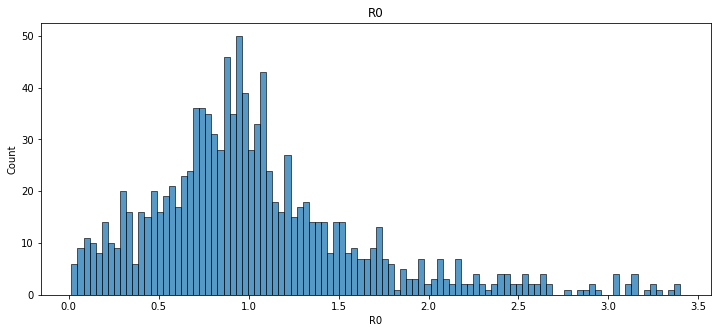

In [2466]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes);
axes.set_title('R0')

In [2467]:
df.R0.describe()

count    1114.000000
mean        1.035258
std         0.599454
min         0.014184
25%         0.677620
50%         0.938764
75%         1.273690
max         3.398876
Name: R0, dtype: float64

# Modelling and Results

pip install xgboost

In [2468]:
#Predictions from January 2021
#df=df[pd.to_datetime(df['Date']) > pd.Timestamp(2020, 5, 1)]
date1=pd.Timestamp(2020, 12, 1)
#date2=pd.Timestamp(2020, 5, 1)
#df=df[(pd.to_datetime(df['Date']) > date2)]
X_1=df[(pd.to_datetime(df['Date']) <= date1)]
X_2=df[(pd.to_datetime(df['Date']) > date1)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['R0']
y_test=X_2['R0']

In [2469]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Date,R0
0,-5.738009,1.759953,-0.698890,-1.608423,1.446390,1.482554,0.696642,-0.913105,-0.716434,-0.577872,0.656501,1.075282,0.688314,0.256233,-0.259233,2020-03-08,0.949187
1,-5.852582,1.696799,-0.707315,-1.492961,1.521432,1.632278,0.763409,-0.949321,-0.734240,-0.357876,0.683413,1.055871,0.644586,0.149544,-0.369897,2020-03-15,0.989293
2,-5.919670,1.629907,-0.727931,-1.397277,1.563316,1.735936,0.811107,-1.026597,-0.737163,-0.157727,0.751029,1.011990,0.648399,0.060481,-0.433155,2020-03-22,1.575758
3,-5.871291,1.631934,-0.654397,-1.390106,1.564338,1.576393,0.712047,-0.990262,-0.749114,-0.283425,0.683891,1.070123,0.623153,0.083112,-0.419924,2020-03-29,1.666209
4,-5.291214,0.942879,-0.131639,-1.379178,1.525650,0.636472,0.291756,-0.768206,-0.952661,-0.832074,0.570714,0.929576,0.280770,0.016422,-0.415999,2020-04-05,0.932399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,2.114144,-0.989884,-0.895288,1.186429,1.143330,-1.170923,-0.764715,0.008939,-0.604430,0.134516,-0.338499,0.119930,-0.372540,-1.271538,0.602772,2020-04-12,1.696078
1543,2.651146,-0.904542,-0.273467,1.319500,0.712387,-1.315479,-0.797446,-0.990496,0.374819,0.359101,-0.319771,0.651618,-0.316559,-1.135486,0.565416,2020-04-19,0.927746
1544,2.890667,-0.845459,-0.315984,1.411230,0.794333,-1.068369,-0.612844,-1.000731,0.581633,0.452163,-0.023129,0.591067,-0.227925,-1.136999,0.593392,NaN,NaN
1545,2.516395,-0.876913,-0.676234,1.427783,1.477724,-1.145515,-0.677486,0.446815,-0.047228,-0.072641,-0.044960,0.304127,-0.361395,-1.138330,0.502444,NaN,NaN


In [2470]:
X_test

,2,3,4,5,6,7,8,9,10,11,12,13,14,Date
40,0.326794,-0.179980,1.166838,-0.519790,0.494910,2.711227,2.079920,0.246628,-1.494933,0.210217,0.346361,-0.175634,-0.590849,2020-12-13
41,0.245678,-0.454024,0.117059,-0.649932,0.292321,1.392311,-1.088938,0.864693,-1.032260,1.308998,0.292975,-0.460125,-0.817389,2020-12-20
42,1.879704,-0.266172,-1.121395,-0.064238,1.281095,1.401933,0.005080,-0.226586,-0.694558,-0.972379,-0.417215,-0.350600,-0.594173,2020-12-27
47,0.968474,-0.228956,-1.463181,0.320921,1.830179,-0.201506,1.195640,0.029084,-0.922558,-0.033906,-0.232892,-0.093950,-0.767156,2021-03-07
48,0.241248,-0.260972,-1.041357,-0.149684,1.610009,0.808511,0.185600,-0.551288,-0.817445,-0.435063,-0.048780,0.239288,-0.747074,2021-03-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,-1.130050,-0.193012,0.661104,-1.481093,-0.597470,0.130985,-0.420261,0.435781,-0.262493,-0.126339,-0.234982,-0.572867,0.611264,2021-01-31
1532,-0.884338,-0.162874,0.400480,-1.398444,-0.740288,-0.973665,0.319261,0.975956,-0.300201,0.415888,-0.171296,-0.653656,0.449161,2021-02-07
1533,-1.027659,-0.058745,0.888842,-1.222217,-0.799546,0.128629,-0.422273,0.602876,-0.439164,-0.209649,-0.207183,-0.801184,0.471044,2021-02-14
1534,-0.934026,0.258903,0.895531,-1.053924,-0.535326,0.060310,-0.444272,0.666334,-0.327067,-0.161204,-0.320647,-0.902920,0.427656,2021-02-21


In [2471]:
#Not used since we are going to predict on unseen future data defined before (date > 01/01/2021)
X=df[df.columns[2:-1]]
y=df['R0']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [2472]:
y_train

0       0.949187
1       0.989293
2       1.575758
3       1.666209
4       0.932399
          ...   
1522    1.169850
1541    0.431746
1542    1.696078
1543    0.927746
1546    0.419890
Name: R0, Length: 791, dtype: float64

## XGBoost Regressor 

### Modelling with GridSearchCV 

In [2473]:
#Mape custom scoring function
def mse(pred, train): 
    return mean_squared_error(train, pred)

In [2474]:
# A parameter grid for XGBoost
params = {'subsample':[0.8,0.9,1],'max_depth': [10,11,12], 'n_estimators':[18,19,20]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(num_boost_rounds=1000) 

grid = GridSearchCV(xgb, params, verbose=1, n_jobs=-1, scoring=make_scorer(mse))

In [2475]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    6.6s finished


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Date

In [2476]:
grid.best_estimator_

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=18, n_jobs=None, num_boost_rounds=1000,
             num_parallel_tree=None, random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=0.8,
             tree_method=None, validate_parameters=None, verbosity=None)

In [2477]:
y_pred=grid.best_estimator_.predict(X_test)
y_pred_train=grid.best_estimator_.predict(X_train)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Date

### XGB Evaluation

#### Test Set

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

#### Train Set

In [ ]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

In [ ]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval.head()

## Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

In [ ]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

In [ ]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

In [ ]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

In [ ]:
_, ax = plt.subplots(figsize=(5,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('frequency')
plt.ylabel('value')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [ ]:
res_df_test

In [2478]:
df.iloc[47]

0          1.76981
1        -0.156536
2         0.968474
3        -0.228956
4         -1.46318
5         0.320921
6          1.83018
7        -0.201506
8          1.19564
9        0.0290837
10       -0.922558
11      -0.0339056
12       -0.232892
13      -0.0939496
14       -0.767156
Date    2021-03-07
R0         1.49089
Name: 47, dtype: object

## Feature importance 

In [2479]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

XGBoostError: need to call fit or load_model beforehand

## Light GBM

### Modelling 

In [2480]:
params = {
    'metric': ['mape'],
    "max_depth":[6,7,8] , 
    "n_estimators":[150,180]
}

# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid = GridSearchCV(lgbm, params)

In [2481]:
%%time
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
grid.fit(X_train, y_train)

TypeError: expected string or bytes-like object

In [2267]:
grid.best_estimator_

LGBMRegressor(max_depth=7, metric='mape', n_estimators=150)

In [2268]:
y_pred = grid.best_estimator_.predict(X_test)
y_pred_train = grid.best_estimator_.predict(X_train)

### Evaluation

#### Test Set

In [2269]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse':rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.5213069506216226
mse score is 0.40136445530497794
rmse score is 0.6335333103357533
r2 score is -0.05253410591827534
mape score is 142.301133843844


#### Train Set

In [2270]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.19865041033337796
mse score is 0.07754565764031544
rmse score is 0.27847020961014024
r2 score is 0.7925506359902914
mape score is 44.589440809443616


In [2271]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
47,1.490888,1.176381,0.314507
48,0.042017,1.026682,0.984665
49,0.472727,0.994866,0.522138
102,1.506276,0.656359,0.849918
103,0.631944,0.861394,0.229449
156,1.733467,0.719118,1.014349
157,1.734682,0.854045,0.880637
158,1.652449,1.016037,0.636412
252,1.274648,0.791204,0.483444
253,0.983886,1.034326,0.050440


## Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

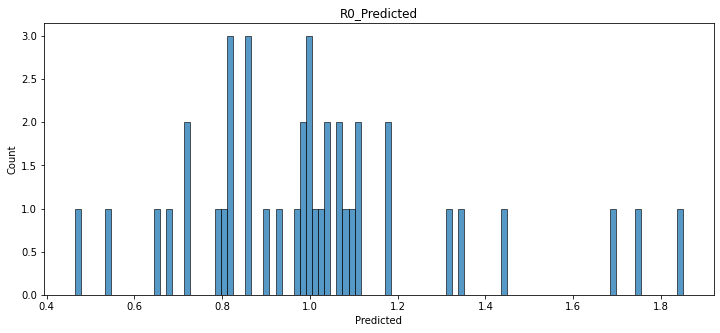

In [2272]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

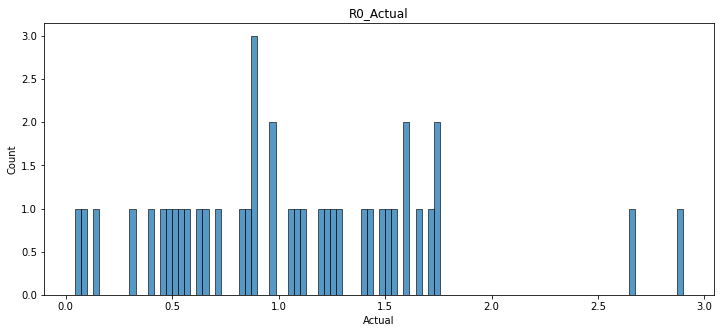

In [2273]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

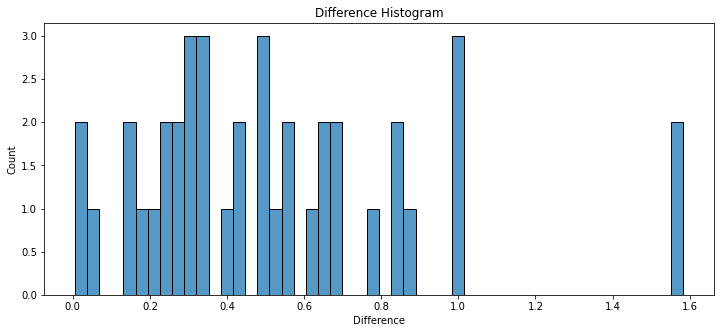

In [2274]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

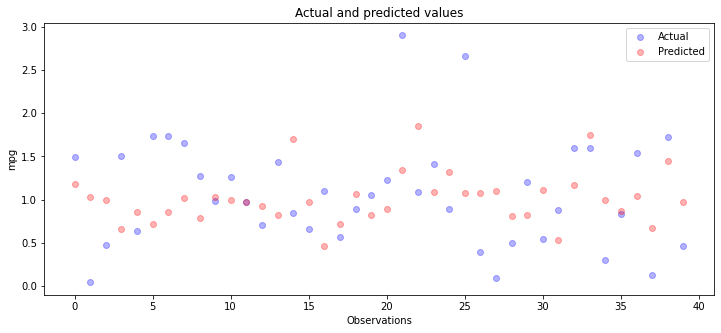

In [2275]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

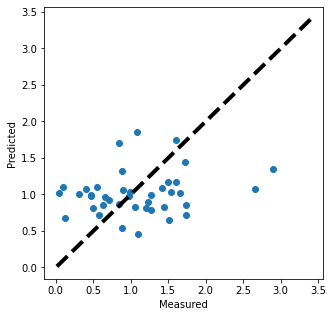

In [2276]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

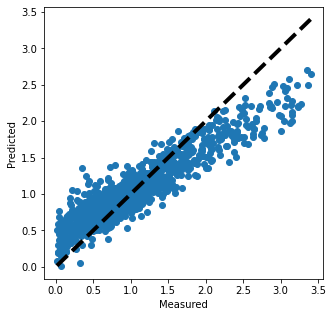

In [2277]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

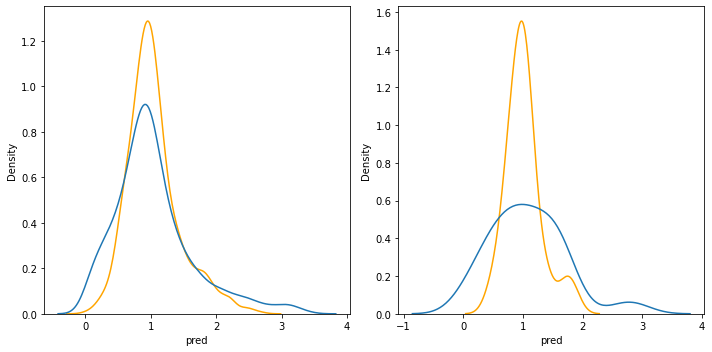

In [2278]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [2279]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
784,1.073587,2.657303,-1.58,1.58,-59.60
156,0.719118,1.733467,-1.01,1.01,-58.52
513,0.463545,1.103194,-0.64,0.64,-57.98
102,0.656359,1.506276,-0.85,0.85,-56.43
622,1.343890,2.900990,-1.56,1.56,-53.67
157,0.854045,1.734682,-0.88,0.88,-50.77
458,0.823852,1.440000,-0.62,0.62,-42.79
1487,0.534508,0.877922,-0.34,0.34,-39.12
158,1.016037,1.652449,-0.64,0.64,-38.51
252,0.791204,1.274648,-0.48,0.48,-37.93


In [2280]:
np.abs(res_df_test[res_df_test['test']>0.1]['dif%']).mean()

61.23315789473685

In [2281]:
res_df_test.sort_values('dif_abs')

,pred,test,dif,dif_abs,dif%
307,0.978526,0.973767,0.00,0.00,0.49
1647,0.865027,0.837349,0.03,0.03,3.31
253,1.034326,0.983886,0.05,0.05,5.13
1593,1.751364,1.599271,0.15,0.15,9.51
514,0.718750,0.569599,0.15,0.15,26.19
567,1.067304,0.894418,0.17,0.17,19.33
308,0.928307,0.709914,0.22,0.22,30.76
103,0.861394,0.631944,0.23,0.23,36.31
568,0.823699,1.059480,-0.24,0.24,-22.25
306,0.994586,1.267287,-0.27,0.27,-21.52


In [2282]:
res_df_test['pred'].describe()

count    40.000000
mean      1.013755
std       0.296687
min       0.463545
25%       0.823814
50%       0.994726
75%       1.093571
max       1.851313
Name: pred, dtype: float64

In [2283]:
res_df_test['test'].describe()

count    40.000000
mean      1.075985
std       0.625387
min       0.042017
25%       0.616358
50%       1.021683
75%       1.494735
max       2.900990
Name: test, dtype: float64

## CatBoost Regressor 

### Modelling 

In [2305]:
ctbst = CatBoostRegressor(learning_rate=0.02, eval_metric='MAPE',depth=8, has_time=True)

ctbst.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)

0:	learn: 0.3407957	test: 0.3466721	best: 0.3466721 (0)	total: 16ms	remaining: 15.9s
1:	learn: 0.3401255	test: 0.3458310	best: 0.3458310 (1)	total: 29.2ms	remaining: 14.6s
2:	learn: 0.3395849	test: 0.3453391	best: 0.3453391 (2)	total: 40.2ms	remaining: 13.4s
3:	learn: 0.3389709	test: 0.3447771	best: 0.3447771 (3)	total: 52.6ms	remaining: 13.1s
4:	learn: 0.3381429	test: 0.3441546	best: 0.3441546 (4)	total: 63.5ms	remaining: 12.6s
5:	learn: 0.3374958	test: 0.3435114	best: 0.3435114 (5)	total: 75.5ms	remaining: 12.5s
6:	learn: 0.3367170	test: 0.3432192	best: 0.3432192 (6)	total: 86.7ms	remaining: 12.3s
7:	learn: 0.3359876	test: 0.3427209	best: 0.3427209 (7)	total: 97.5ms	remaining: 12.1s
8:	learn: 0.3353540	test: 0.3422807	best: 0.3422807 (8)	total: 119ms	remaining: 13.1s
9:	learn: 0.3347058	test: 0.3417653	best: 0.3417653 (9)	total: 133ms	remaining: 13.1s
10:	learn: 0.3340914	test: 0.3413248	best: 0.3413248 (10)	total: 144ms	remaining: 12.9s
11:	learn: 0.3334477	test: 0.3406547	best: 0.3

116:	learn: 0.2932559	test: 0.3264737	best: 0.3264737 (116)	total: 979ms	remaining: 7.39s
117:	learn: 0.2928861	test: 0.3266459	best: 0.3264737 (116)	total: 1.03s	remaining: 7.72s
118:	learn: 0.2925010	test: 0.3267351	best: 0.3264737 (116)	total: 1.17s	remaining: 8.64s
119:	learn: 0.2923504	test: 0.3267772	best: 0.3264737 (116)	total: 1.18s	remaining: 8.66s
120:	learn: 0.2920709	test: 0.3269281	best: 0.3264737 (116)	total: 1.19s	remaining: 8.66s
121:	learn: 0.2917595	test: 0.3268823	best: 0.3264737 (116)	total: 1.23s	remaining: 8.86s
122:	learn: 0.2915199	test: 0.3267457	best: 0.3264737 (116)	total: 1.24s	remaining: 8.85s
123:	learn: 0.2912970	test: 0.3265391	best: 0.3264737 (116)	total: 1.25s	remaining: 8.84s
124:	learn: 0.2910887	test: 0.3266285	best: 0.3264737 (116)	total: 1.26s	remaining: 8.81s
125:	learn: 0.2909020	test: 0.3265732	best: 0.3264737 (116)	total: 1.26s	remaining: 8.77s
126:	learn: 0.2905366	test: 0.3265028	best: 0.3264737 (116)	total: 1.27s	remaining: 8.73s
127:	learn

230:	learn: 0.2647380	test: 0.3248766	best: 0.3242864 (209)	total: 1.96s	remaining: 6.53s
231:	learn: 0.2646386	test: 0.3248221	best: 0.3242864 (209)	total: 1.97s	remaining: 6.53s
232:	learn: 0.2644810	test: 0.3249142	best: 0.3242864 (209)	total: 1.98s	remaining: 6.53s
233:	learn: 0.2642407	test: 0.3249047	best: 0.3242864 (209)	total: 1.99s	remaining: 6.52s
234:	learn: 0.2641258	test: 0.3247339	best: 0.3242864 (209)	total: 2s	remaining: 6.51s
235:	learn: 0.2640288	test: 0.3248717	best: 0.3242864 (209)	total: 2.01s	remaining: 6.5s
236:	learn: 0.2640212	test: 0.3249461	best: 0.3242864 (209)	total: 2.01s	remaining: 6.47s
237:	learn: 0.2638300	test: 0.3248750	best: 0.3242864 (209)	total: 2.02s	remaining: 6.46s
238:	learn: 0.2636448	test: 0.3248418	best: 0.3242864 (209)	total: 2.02s	remaining: 6.44s
239:	learn: 0.2634612	test: 0.3249216	best: 0.3242864 (209)	total: 2.03s	remaining: 6.43s
240:	learn: 0.2632152	test: 0.3249949	best: 0.3242864 (209)	total: 2.04s	remaining: 6.41s
241:	learn: 0.

334:	learn: 0.2446462	test: 0.3248606	best: 0.3242864 (209)	total: 2.75s	remaining: 5.45s
335:	learn: 0.2445429	test: 0.3247739	best: 0.3242864 (209)	total: 2.75s	remaining: 5.44s
336:	learn: 0.2444275	test: 0.3246898	best: 0.3242864 (209)	total: 2.77s	remaining: 5.45s
337:	learn: 0.2443566	test: 0.3246803	best: 0.3242864 (209)	total: 2.79s	remaining: 5.46s
338:	learn: 0.2441920	test: 0.3246732	best: 0.3242864 (209)	total: 2.8s	remaining: 5.46s
339:	learn: 0.2439484	test: 0.3247294	best: 0.3242864 (209)	total: 2.81s	remaining: 5.46s
340:	learn: 0.2438132	test: 0.3246908	best: 0.3242864 (209)	total: 2.82s	remaining: 5.46s
341:	learn: 0.2437507	test: 0.3246809	best: 0.3242864 (209)	total: 2.83s	remaining: 5.45s
342:	learn: 0.2434784	test: 0.3246548	best: 0.3242864 (209)	total: 2.84s	remaining: 5.45s
343:	learn: 0.2433643	test: 0.3246258	best: 0.3242864 (209)	total: 2.86s	remaining: 5.45s
344:	learn: 0.2432867	test: 0.3247221	best: 0.3242864 (209)	total: 2.86s	remaining: 5.43s
345:	learn:

448:	learn: 0.2283235	test: 0.3251783	best: 0.3242864 (209)	total: 3.72s	remaining: 4.56s
449:	learn: 0.2282157	test: 0.3251950	best: 0.3242864 (209)	total: 3.73s	remaining: 4.56s
450:	learn: 0.2280440	test: 0.3252287	best: 0.3242864 (209)	total: 3.74s	remaining: 4.56s
451:	learn: 0.2279586	test: 0.3252921	best: 0.3242864 (209)	total: 3.75s	remaining: 4.55s
452:	learn: 0.2278632	test: 0.3252908	best: 0.3242864 (209)	total: 3.76s	remaining: 4.54s
453:	learn: 0.2277515	test: 0.3252909	best: 0.3242864 (209)	total: 3.77s	remaining: 4.53s
454:	learn: 0.2276592	test: 0.3253135	best: 0.3242864 (209)	total: 3.78s	remaining: 4.52s
455:	learn: 0.2273615	test: 0.3254780	best: 0.3242864 (209)	total: 3.78s	remaining: 4.51s
456:	learn: 0.2273357	test: 0.3254506	best: 0.3242864 (209)	total: 3.79s	remaining: 4.5s
457:	learn: 0.2271244	test: 0.3256165	best: 0.3242864 (209)	total: 3.79s	remaining: 4.49s
458:	learn: 0.2269931	test: 0.3256268	best: 0.3242864 (209)	total: 3.8s	remaining: 4.48s
459:	learn: 

561:	learn: 0.2130883	test: 0.3263754	best: 0.3242864 (209)	total: 4.72s	remaining: 3.67s
562:	learn: 0.2130025	test: 0.3263788	best: 0.3242864 (209)	total: 4.73s	remaining: 3.67s
563:	learn: 0.2129252	test: 0.3263646	best: 0.3242864 (209)	total: 4.74s	remaining: 3.67s
564:	learn: 0.2127304	test: 0.3264052	best: 0.3242864 (209)	total: 4.75s	remaining: 3.66s
565:	learn: 0.2126255	test: 0.3264232	best: 0.3242864 (209)	total: 4.76s	remaining: 3.65s
566:	learn: 0.2125338	test: 0.3264424	best: 0.3242864 (209)	total: 4.77s	remaining: 3.64s
567:	learn: 0.2123960	test: 0.3262034	best: 0.3242864 (209)	total: 4.78s	remaining: 3.63s
568:	learn: 0.2122957	test: 0.3262700	best: 0.3242864 (209)	total: 4.79s	remaining: 3.63s
569:	learn: 0.2121368	test: 0.3262102	best: 0.3242864 (209)	total: 4.79s	remaining: 3.62s
570:	learn: 0.2120183	test: 0.3261622	best: 0.3242864 (209)	total: 4.8s	remaining: 3.61s
571:	learn: 0.2118627	test: 0.3261833	best: 0.3242864 (209)	total: 4.81s	remaining: 3.6s
572:	learn: 

666:	learn: 0.2000306	test: 0.3269790	best: 0.3242864 (209)	total: 5.72s	remaining: 2.86s
667:	learn: 0.1998494	test: 0.3270331	best: 0.3242864 (209)	total: 5.74s	remaining: 2.85s
668:	learn: 0.1996762	test: 0.3271121	best: 0.3242864 (209)	total: 5.75s	remaining: 2.84s
669:	learn: 0.1995546	test: 0.3270326	best: 0.3242864 (209)	total: 5.75s	remaining: 2.83s
670:	learn: 0.1993470	test: 0.3271294	best: 0.3242864 (209)	total: 5.76s	remaining: 2.83s
671:	learn: 0.1992562	test: 0.3270558	best: 0.3242864 (209)	total: 5.77s	remaining: 2.82s
672:	learn: 0.1991389	test: 0.3269701	best: 0.3242864 (209)	total: 5.78s	remaining: 2.81s
673:	learn: 0.1989836	test: 0.3270696	best: 0.3242864 (209)	total: 5.78s	remaining: 2.8s
674:	learn: 0.1988759	test: 0.3271069	best: 0.3242864 (209)	total: 5.79s	remaining: 2.79s
675:	learn: 0.1987894	test: 0.3271618	best: 0.3242864 (209)	total: 5.8s	remaining: 2.78s
676:	learn: 0.1987576	test: 0.3271631	best: 0.3242864 (209)	total: 5.8s	remaining: 2.77s
677:	learn: 0

765:	learn: 0.1887530	test: 0.3268682	best: 0.3242864 (209)	total: 6.5s	remaining: 1.98s
766:	learn: 0.1886073	test: 0.3267956	best: 0.3242864 (209)	total: 6.51s	remaining: 1.98s
767:	learn: 0.1885750	test: 0.3267573	best: 0.3242864 (209)	total: 6.52s	remaining: 1.97s
768:	learn: 0.1884520	test: 0.3267682	best: 0.3242864 (209)	total: 6.53s	remaining: 1.96s
769:	learn: 0.1883115	test: 0.3266900	best: 0.3242864 (209)	total: 6.53s	remaining: 1.95s
770:	learn: 0.1882697	test: 0.3266188	best: 0.3242864 (209)	total: 6.55s	remaining: 1.94s
771:	learn: 0.1882210	test: 0.3266052	best: 0.3242864 (209)	total: 6.56s	remaining: 1.94s
772:	learn: 0.1881875	test: 0.3266345	best: 0.3242864 (209)	total: 6.56s	remaining: 1.93s
773:	learn: 0.1880701	test: 0.3266497	best: 0.3242864 (209)	total: 6.57s	remaining: 1.92s
774:	learn: 0.1880515	test: 0.3266479	best: 0.3242864 (209)	total: 6.58s	remaining: 1.91s
775:	learn: 0.1879963	test: 0.3267283	best: 0.3242864 (209)	total: 6.58s	remaining: 1.9s
776:	learn: 

866:	learn: 0.1781920	test: 0.3272988	best: 0.3242864 (209)	total: 7.28s	remaining: 1.12s
867:	learn: 0.1780583	test: 0.3271426	best: 0.3242864 (209)	total: 7.29s	remaining: 1.11s
868:	learn: 0.1779033	test: 0.3271870	best: 0.3242864 (209)	total: 7.31s	remaining: 1.1s
869:	learn: 0.1777461	test: 0.3271499	best: 0.3242864 (209)	total: 7.33s	remaining: 1.09s
870:	learn: 0.1776742	test: 0.3270520	best: 0.3242864 (209)	total: 7.34s	remaining: 1.09s
871:	learn: 0.1775408	test: 0.3271479	best: 0.3242864 (209)	total: 7.35s	remaining: 1.08s
872:	learn: 0.1774388	test: 0.3271783	best: 0.3242864 (209)	total: 7.35s	remaining: 1.07s
873:	learn: 0.1773344	test: 0.3270735	best: 0.3242864 (209)	total: 7.36s	remaining: 1.06s
874:	learn: 0.1772141	test: 0.3270099	best: 0.3242864 (209)	total: 7.37s	remaining: 1.05s
875:	learn: 0.1771030	test: 0.3270184	best: 0.3242864 (209)	total: 7.37s	remaining: 1.04s
876:	learn: 0.1770511	test: 0.3270096	best: 0.3242864 (209)	total: 7.38s	remaining: 1.03s
877:	learn:

967:	learn: 0.1680416	test: 0.3273838	best: 0.3242864 (209)	total: 8.07s	remaining: 267ms
968:	learn: 0.1679283	test: 0.3272532	best: 0.3242864 (209)	total: 8.08s	remaining: 258ms
969:	learn: 0.1678110	test: 0.3272826	best: 0.3242864 (209)	total: 8.09s	remaining: 250ms
970:	learn: 0.1677674	test: 0.3272994	best: 0.3242864 (209)	total: 8.1s	remaining: 242ms
971:	learn: 0.1676645	test: 0.3272849	best: 0.3242864 (209)	total: 8.11s	remaining: 234ms
972:	learn: 0.1675406	test: 0.3272731	best: 0.3242864 (209)	total: 8.12s	remaining: 225ms
973:	learn: 0.1674350	test: 0.3273062	best: 0.3242864 (209)	total: 8.12s	remaining: 217ms
974:	learn: 0.1673787	test: 0.3273286	best: 0.3242864 (209)	total: 8.13s	remaining: 208ms
975:	learn: 0.1672877	test: 0.3273521	best: 0.3242864 (209)	total: 8.14s	remaining: 200ms
976:	learn: 0.1671350	test: 0.3273779	best: 0.3242864 (209)	total: 8.14s	remaining: 192ms
977:	learn: 0.1670782	test: 0.3273990	best: 0.3242864 (209)	total: 8.15s	remaining: 183ms
978:	learn:

In [2306]:
y_pred = ctbst.predict(X_test)
y_pred_train = ctbst.predict(X_train)

### Evaluation

#### Test Set

In [2307]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.4047692863210336
mse score is 0.3006960090449504
rmse score is 0.5483575558382965
r2 score is 0.05520864541516379
mape score is 123.30745147159024


#### Train Set

In [2308]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.35599909739073726
mse score is 0.2452775812765727
rmse score is 0.49525506688631943
r2 score is 0.36455805508694705
mape score is 88.85176104969213


In [2309]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
47,1.490888,1.089162,0.401726
48,0.042017,1.045041,1.003024
49,0.472727,1.074179,0.601452
89,0.679088,0.879993,0.200905
90,0.531956,0.911152,0.379196
...,...,...,...
2037,0.821006,0.941524,0.120518
2038,0.922972,0.888990,0.033983
2039,0.870835,0.874398,0.003563
2040,0.830681,0.906003,0.075323


### Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

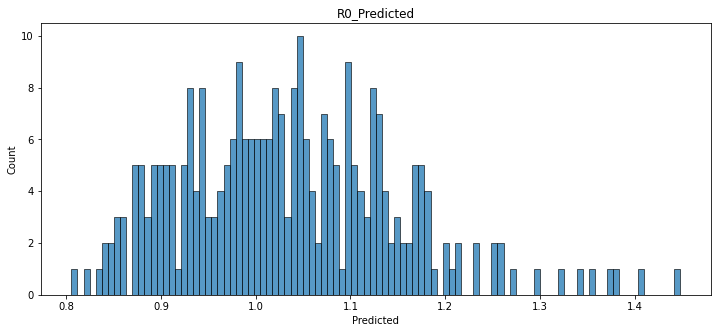

In [2310]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

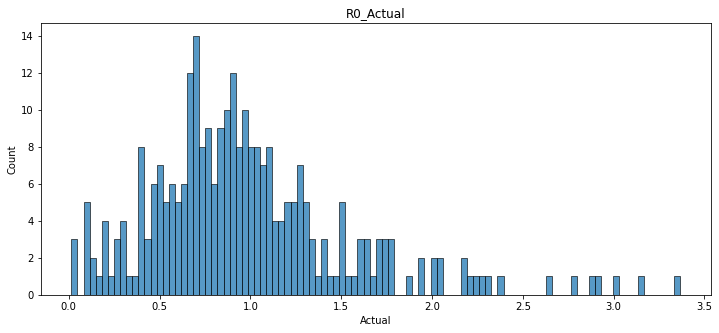

In [2311]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

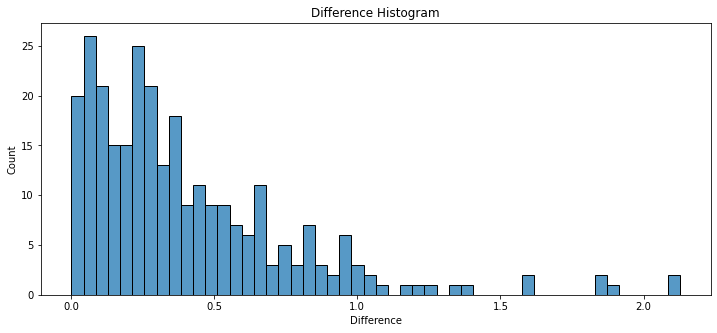

In [2312]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

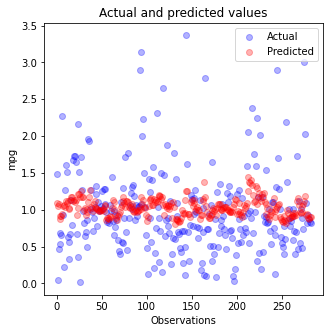

In [2313]:
_, ax = plt.subplots(figsize=(5,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

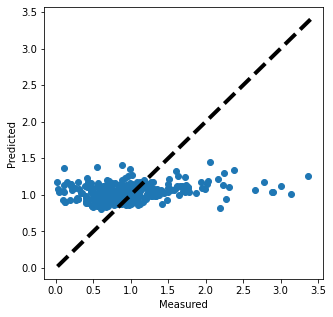

In [2314]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

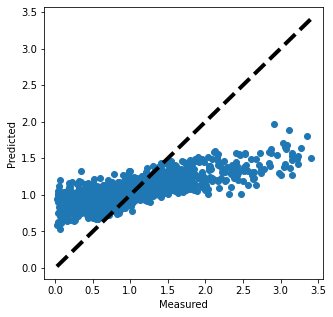

In [2315]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

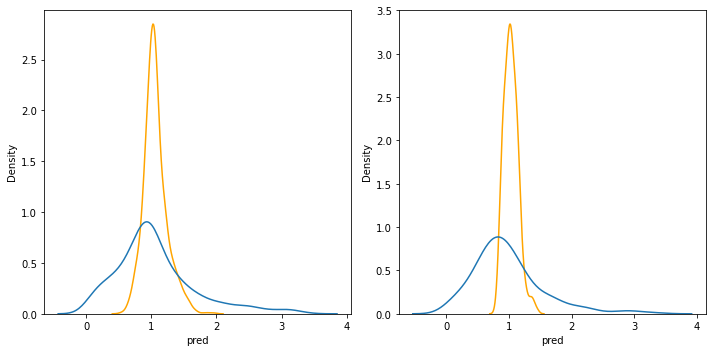

In [2316]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [2317]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
663,1.015133,3.142857,-2.13,2.13,-67.70
622,1.036878,2.900990,-1.86,1.86,-64.26
1744,1.038276,2.891479,-1.85,1.85,-64.09
1024,1.257012,3.366412,-2.11,2.11,-62.66
1948,1.123732,3.005882,-1.88,1.88,-62.62
...,...,...,...,...,...
1229,1.050590,0.098240,0.95,0.95,969.41
1221,1.373952,0.110345,1.26,1.26,1145.14
48,1.045041,0.042017,1.00,1.00,2387.20
1475,1.079104,0.032086,1.05,1.05,3263.21


In [2016]:
df.columns

Index(['Code', 'Date', 'restrictions_internal_movements',
       'close_public_transport', 'stay_home_requirements',
       'restriction_gatherings', 'cancel_public_events', 'Holiday', 'temp',
       'prcp', 'urban_population', 'total_vaccinations_per_100',
       'df_population_gr_65', 'ExcessmortalityPscoresallagesPrev18days',
       'deaths_prev_18', 'accumulated', 'mobility', 'tourism', 'awareness',
       'work_life_closures', 'government_support', 'hospital_availability',
       'youth_effect', 'R0'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

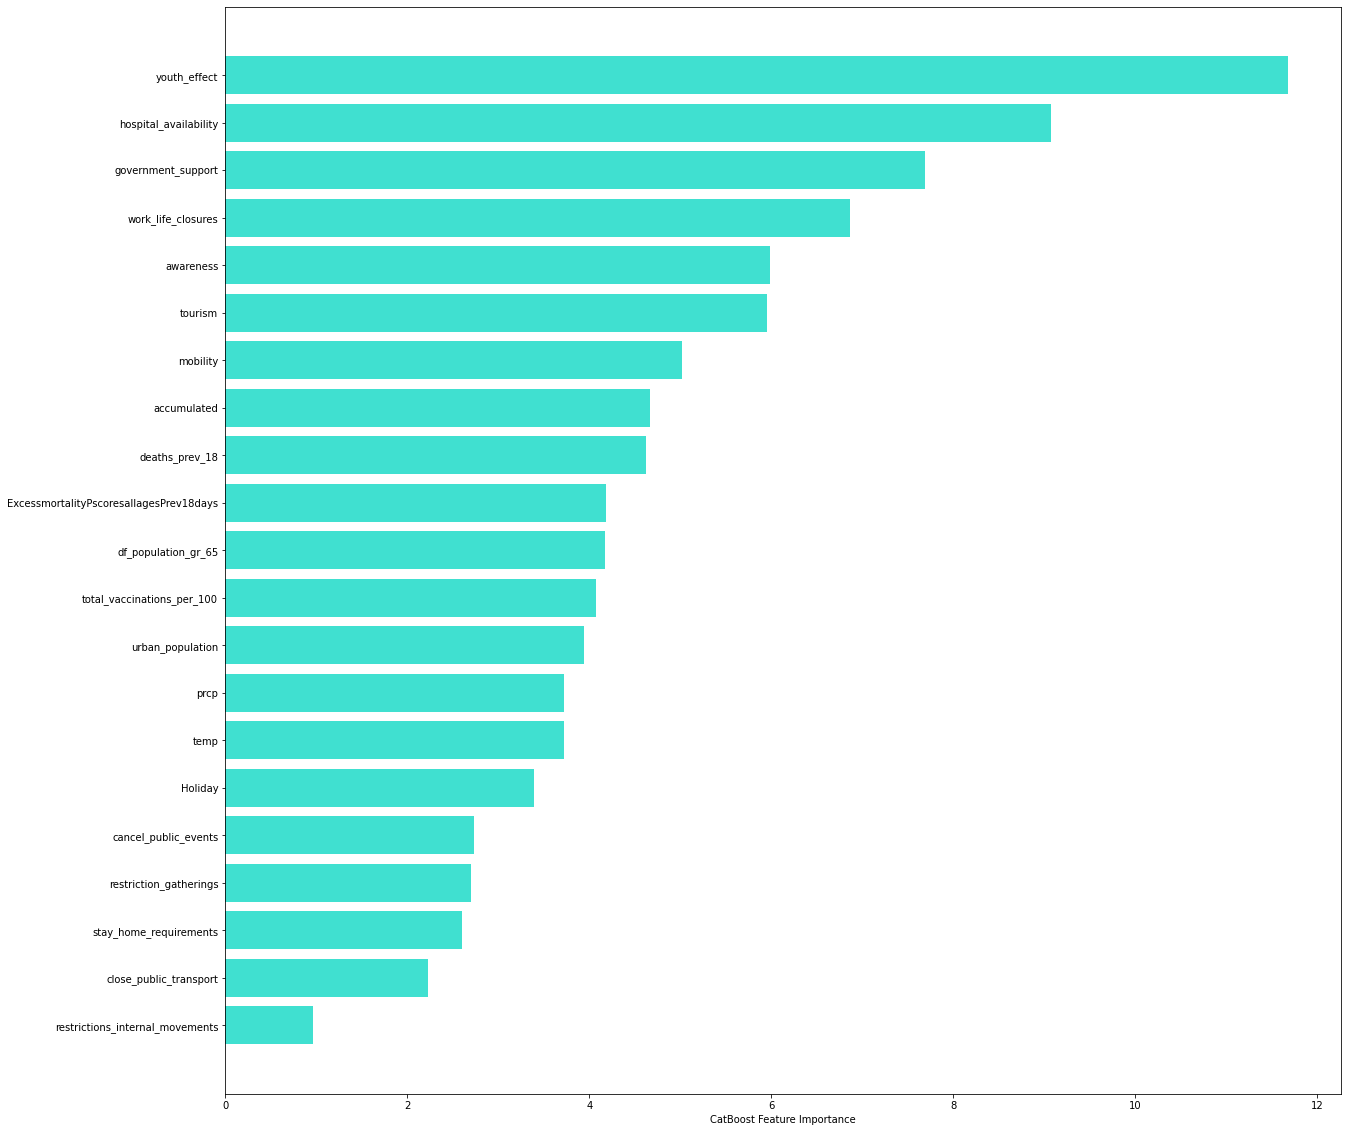

In [2018]:
sorted_feature_importance = ctbst.feature_importances_.argsort()
plt.barh(df[df.columns[2:-1]].columns, 
        ctbst.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [2447]:
explainer = shap.TreeExplainer(ctbst)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names = df[df.columns[2:-1]].columns)

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 9 should be feature with name ExcessmortalityPscoresallagesPrev18days (found Excess mortality P-scores, all ages Prev 18 days).

## Cross Validation

In [1279]:
aux=df.copy()
aux=aux.sort_values('Date')
X=aux[aux.columns[2:-1]]
y=aux[aux.columns[-1]]

In [372]:
k = 4
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    ctbst.fit(X_train, y_train)
    pred_values = ctbst.predict(X_test)
     
    acc = np.mean(np.abs((y_test - pred_values) / y_test)) * 100
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

0:	learn: 0.0928692	total: 17.8ms	remaining: 17.8s
1:	learn: 0.0927808	total: 33ms	remaining: 16.5s
2:	learn: 0.0926898	total: 49.9ms	remaining: 16.6s
3:	learn: 0.0926690	total: 61.2ms	remaining: 15.2s
4:	learn: 0.0926096	total: 83.7ms	remaining: 16.7s
5:	learn: 0.0925672	total: 92.7ms	remaining: 15.4s
6:	learn: 0.0925076	total: 101ms	remaining: 14.4s
7:	learn: 0.0924402	total: 111ms	remaining: 13.7s
8:	learn: 0.0923983	total: 119ms	remaining: 13.1s
9:	learn: 0.0923206	total: 133ms	remaining: 13.2s
10:	learn: 0.0922413	total: 147ms	remaining: 13.2s
11:	learn: 0.0921983	total: 160ms	remaining: 13.2s
12:	learn: 0.0921472	total: 173ms	remaining: 13.1s
13:	learn: 0.0920926	total: 186ms	remaining: 13.1s
14:	learn: 0.0920566	total: 199ms	remaining: 13.1s
15:	learn: 0.0919925	total: 210ms	remaining: 12.9s
16:	learn: 0.0919365	total: 240ms	remaining: 13.9s
17:	learn: 0.0918975	total: 258ms	remaining: 14.1s
18:	learn: 0.0918720	total: 271ms	remaining: 14s
19:	learn: 0.0918079	total: 288ms	remai

166:	learn: 0.0873629	total: 2.17s	remaining: 10.8s
167:	learn: 0.0873025	total: 2.18s	remaining: 10.8s
168:	learn: 0.0872997	total: 2.2s	remaining: 10.8s
169:	learn: 0.0872786	total: 2.22s	remaining: 10.8s
170:	learn: 0.0872208	total: 2.23s	remaining: 10.8s
171:	learn: 0.0871919	total: 2.25s	remaining: 10.8s
172:	learn: 0.0871751	total: 2.27s	remaining: 10.8s
173:	learn: 0.0871680	total: 2.28s	remaining: 10.8s
174:	learn: 0.0871426	total: 2.3s	remaining: 10.8s
175:	learn: 0.0870923	total: 2.31s	remaining: 10.8s
176:	learn: 0.0870734	total: 2.32s	remaining: 10.8s
177:	learn: 0.0870678	total: 2.33s	remaining: 10.8s
178:	learn: 0.0870405	total: 2.34s	remaining: 10.7s
179:	learn: 0.0870445	total: 2.35s	remaining: 10.7s
180:	learn: 0.0870334	total: 2.36s	remaining: 10.7s
181:	learn: 0.0870345	total: 2.37s	remaining: 10.6s
182:	learn: 0.0870171	total: 2.38s	remaining: 10.6s
183:	learn: 0.0869906	total: 2.39s	remaining: 10.6s
184:	learn: 0.0869361	total: 2.4s	remaining: 10.6s
185:	learn: 0.0

335:	learn: 0.0821901	total: 3.97s	remaining: 7.84s
336:	learn: 0.0821690	total: 3.98s	remaining: 7.84s
337:	learn: 0.0821394	total: 4s	remaining: 7.83s
338:	learn: 0.0820678	total: 4.01s	remaining: 7.82s
339:	learn: 0.0820403	total: 4.02s	remaining: 7.8s
340:	learn: 0.0819924	total: 4.04s	remaining: 7.8s
341:	learn: 0.0819382	total: 4.05s	remaining: 7.79s
342:	learn: 0.0818908	total: 4.06s	remaining: 7.78s
343:	learn: 0.0818892	total: 4.08s	remaining: 7.77s
344:	learn: 0.0818680	total: 4.09s	remaining: 7.76s
345:	learn: 0.0818341	total: 4.11s	remaining: 7.77s
346:	learn: 0.0817945	total: 4.14s	remaining: 7.8s
347:	learn: 0.0817651	total: 4.17s	remaining: 7.82s
348:	learn: 0.0817385	total: 4.21s	remaining: 7.85s
349:	learn: 0.0817049	total: 4.22s	remaining: 7.84s
350:	learn: 0.0816870	total: 4.24s	remaining: 7.85s
351:	learn: 0.0816749	total: 4.27s	remaining: 7.86s
352:	learn: 0.0816392	total: 4.29s	remaining: 7.87s
353:	learn: 0.0816264	total: 4.32s	remaining: 7.88s
354:	learn: 0.0816

496:	learn: 0.0776594	total: 7.17s	remaining: 7.26s
497:	learn: 0.0776286	total: 7.19s	remaining: 7.25s
498:	learn: 0.0776085	total: 7.21s	remaining: 7.24s
499:	learn: 0.0775791	total: 7.24s	remaining: 7.24s
500:	learn: 0.0775692	total: 7.26s	remaining: 7.23s
501:	learn: 0.0775382	total: 7.27s	remaining: 7.21s
502:	learn: 0.0774993	total: 7.29s	remaining: 7.2s
503:	learn: 0.0774654	total: 7.3s	remaining: 7.18s
504:	learn: 0.0774052	total: 7.3s	remaining: 7.16s
505:	learn: 0.0773896	total: 7.31s	remaining: 7.14s
506:	learn: 0.0773603	total: 7.32s	remaining: 7.12s
507:	learn: 0.0773363	total: 7.33s	remaining: 7.1s
508:	learn: 0.0773251	total: 7.34s	remaining: 7.08s
509:	learn: 0.0773124	total: 7.35s	remaining: 7.06s
510:	learn: 0.0772935	total: 7.35s	remaining: 7.04s
511:	learn: 0.0772749	total: 7.36s	remaining: 7.02s
512:	learn: 0.0772160	total: 7.37s	remaining: 7s
513:	learn: 0.0771966	total: 7.38s	remaining: 6.98s
514:	learn: 0.0771668	total: 7.4s	remaining: 6.96s
515:	learn: 0.077132

662:	learn: 0.0719031	total: 9.01s	remaining: 4.58s
663:	learn: 0.0718902	total: 9.03s	remaining: 4.57s
664:	learn: 0.0718382	total: 9.04s	remaining: 4.56s
665:	learn: 0.0718129	total: 9.05s	remaining: 4.54s
666:	learn: 0.0717790	total: 9.06s	remaining: 4.53s
667:	learn: 0.0717072	total: 9.07s	remaining: 4.51s
668:	learn: 0.0716742	total: 9.08s	remaining: 4.49s
669:	learn: 0.0716639	total: 9.09s	remaining: 4.47s
670:	learn: 0.0716363	total: 9.09s	remaining: 4.46s
671:	learn: 0.0716127	total: 9.1s	remaining: 4.44s
672:	learn: 0.0715665	total: 9.11s	remaining: 4.42s
673:	learn: 0.0715172	total: 9.12s	remaining: 4.41s
674:	learn: 0.0714945	total: 9.12s	remaining: 4.39s
675:	learn: 0.0714799	total: 9.13s	remaining: 4.38s
676:	learn: 0.0714122	total: 9.15s	remaining: 4.36s
677:	learn: 0.0714030	total: 9.16s	remaining: 4.35s
678:	learn: 0.0713758	total: 9.16s	remaining: 4.33s
679:	learn: 0.0713554	total: 9.17s	remaining: 4.32s
680:	learn: 0.0713211	total: 9.18s	remaining: 4.3s
681:	learn: 0.

843:	learn: 0.0657513	total: 10.6s	remaining: 1.96s
844:	learn: 0.0657223	total: 10.6s	remaining: 1.95s
845:	learn: 0.0657048	total: 10.6s	remaining: 1.93s
846:	learn: 0.0656604	total: 10.6s	remaining: 1.92s
847:	learn: 0.0656383	total: 10.6s	remaining: 1.91s
848:	learn: 0.0656004	total: 10.6s	remaining: 1.89s
849:	learn: 0.0655835	total: 10.7s	remaining: 1.88s
850:	learn: 0.0655619	total: 10.7s	remaining: 1.87s
851:	learn: 0.0655099	total: 10.7s	remaining: 1.85s
852:	learn: 0.0654471	total: 10.7s	remaining: 1.84s
853:	learn: 0.0654029	total: 10.7s	remaining: 1.83s
854:	learn: 0.0653789	total: 10.7s	remaining: 1.81s
855:	learn: 0.0653754	total: 10.7s	remaining: 1.8s
856:	learn: 0.0653448	total: 10.7s	remaining: 1.79s
857:	learn: 0.0653317	total: 10.7s	remaining: 1.77s
858:	learn: 0.0653025	total: 10.7s	remaining: 1.76s
859:	learn: 0.0652954	total: 10.7s	remaining: 1.75s
860:	learn: 0.0652692	total: 10.7s	remaining: 1.73s
861:	learn: 0.0652265	total: 10.7s	remaining: 1.72s
862:	learn: 0

25:	learn: 0.0872887	total: 207ms	remaining: 7.77s
26:	learn: 0.0871977	total: 221ms	remaining: 7.95s
27:	learn: 0.0870925	total: 235ms	remaining: 8.14s
28:	learn: 0.0870072	total: 246ms	remaining: 8.23s
29:	learn: 0.0869529	total: 256ms	remaining: 8.29s
30:	learn: 0.0868847	total: 265ms	remaining: 8.27s
31:	learn: 0.0868126	total: 273ms	remaining: 8.24s
32:	learn: 0.0867317	total: 280ms	remaining: 8.2s
33:	learn: 0.0866720	total: 287ms	remaining: 8.15s
34:	learn: 0.0866289	total: 294ms	remaining: 8.11s
35:	learn: 0.0865601	total: 302ms	remaining: 8.08s
36:	learn: 0.0865028	total: 309ms	remaining: 8.03s
37:	learn: 0.0864398	total: 316ms	remaining: 8s
38:	learn: 0.0863860	total: 323ms	remaining: 7.96s
39:	learn: 0.0863416	total: 330ms	remaining: 7.93s
40:	learn: 0.0862569	total: 338ms	remaining: 7.9s
41:	learn: 0.0861873	total: 345ms	remaining: 7.87s
42:	learn: 0.0861506	total: 352ms	remaining: 7.83s
43:	learn: 0.0860869	total: 359ms	remaining: 7.8s
44:	learn: 0.0860081	total: 366ms	rem

190:	learn: 0.0785417	total: 1.61s	remaining: 6.81s
191:	learn: 0.0785105	total: 1.62s	remaining: 6.82s
192:	learn: 0.0784540	total: 1.63s	remaining: 6.83s
193:	learn: 0.0784293	total: 1.64s	remaining: 6.83s
194:	learn: 0.0784006	total: 1.65s	remaining: 6.82s
195:	learn: 0.0783850	total: 1.66s	remaining: 6.81s
196:	learn: 0.0783315	total: 1.67s	remaining: 6.79s
197:	learn: 0.0782619	total: 1.67s	remaining: 6.78s
198:	learn: 0.0782110	total: 1.68s	remaining: 6.77s
199:	learn: 0.0781850	total: 1.69s	remaining: 6.76s
200:	learn: 0.0781426	total: 1.7s	remaining: 6.76s
201:	learn: 0.0780733	total: 1.71s	remaining: 6.75s
202:	learn: 0.0780332	total: 1.72s	remaining: 6.74s
203:	learn: 0.0779850	total: 1.72s	remaining: 6.73s
204:	learn: 0.0779403	total: 1.73s	remaining: 6.71s
205:	learn: 0.0778754	total: 1.74s	remaining: 6.7s
206:	learn: 0.0778297	total: 1.75s	remaining: 6.69s
207:	learn: 0.0777790	total: 1.75s	remaining: 6.68s
208:	learn: 0.0777309	total: 1.76s	remaining: 6.67s
209:	learn: 0.

359:	learn: 0.0715815	total: 2.99s	remaining: 5.31s
360:	learn: 0.0715450	total: 3.01s	remaining: 5.33s
361:	learn: 0.0715084	total: 3.02s	remaining: 5.33s
362:	learn: 0.0714847	total: 3.03s	remaining: 5.32s
363:	learn: 0.0714675	total: 3.04s	remaining: 5.31s
364:	learn: 0.0714390	total: 3.05s	remaining: 5.3s
365:	learn: 0.0714175	total: 3.05s	remaining: 5.29s
366:	learn: 0.0714042	total: 3.06s	remaining: 5.28s
367:	learn: 0.0713733	total: 3.07s	remaining: 5.27s
368:	learn: 0.0713501	total: 3.08s	remaining: 5.26s
369:	learn: 0.0713330	total: 3.08s	remaining: 5.25s
370:	learn: 0.0712936	total: 3.09s	remaining: 5.24s
371:	learn: 0.0712716	total: 3.1s	remaining: 5.23s
372:	learn: 0.0712402	total: 3.1s	remaining: 5.22s
373:	learn: 0.0712288	total: 3.11s	remaining: 5.21s
374:	learn: 0.0711997	total: 3.12s	remaining: 5.2s
375:	learn: 0.0711589	total: 3.13s	remaining: 5.19s
376:	learn: 0.0711313	total: 3.14s	remaining: 5.18s
377:	learn: 0.0711091	total: 3.14s	remaining: 5.17s
378:	learn: 0.07

530:	learn: 0.0654580	total: 4.4s	remaining: 3.88s
531:	learn: 0.0654172	total: 4.41s	remaining: 3.88s
532:	learn: 0.0653917	total: 4.43s	remaining: 3.88s
533:	learn: 0.0653388	total: 4.44s	remaining: 3.87s
534:	learn: 0.0653105	total: 4.45s	remaining: 3.86s
535:	learn: 0.0652783	total: 4.45s	remaining: 3.85s
536:	learn: 0.0652373	total: 4.46s	remaining: 3.85s
537:	learn: 0.0652189	total: 4.47s	remaining: 3.84s
538:	learn: 0.0651381	total: 4.47s	remaining: 3.83s
539:	learn: 0.0651252	total: 4.48s	remaining: 3.82s
540:	learn: 0.0651009	total: 4.49s	remaining: 3.81s
541:	learn: 0.0650686	total: 4.5s	remaining: 3.8s
542:	learn: 0.0650398	total: 4.51s	remaining: 3.8s
543:	learn: 0.0649986	total: 4.52s	remaining: 3.79s
544:	learn: 0.0649875	total: 4.53s	remaining: 3.78s
545:	learn: 0.0649717	total: 4.54s	remaining: 3.77s
546:	learn: 0.0649575	total: 4.54s	remaining: 3.76s
547:	learn: 0.0648800	total: 4.55s	remaining: 3.75s
548:	learn: 0.0648494	total: 4.56s	remaining: 3.75s
549:	learn: 0.06

699:	learn: 0.0596060	total: 5.79s	remaining: 2.48s
700:	learn: 0.0595284	total: 5.81s	remaining: 2.48s
701:	learn: 0.0594881	total: 5.82s	remaining: 2.47s
702:	learn: 0.0594689	total: 5.83s	remaining: 2.46s
703:	learn: 0.0594106	total: 5.84s	remaining: 2.45s
704:	learn: 0.0593917	total: 5.85s	remaining: 2.45s
705:	learn: 0.0593681	total: 5.85s	remaining: 2.44s
706:	learn: 0.0593032	total: 5.86s	remaining: 2.43s
707:	learn: 0.0592600	total: 5.87s	remaining: 2.42s
708:	learn: 0.0592149	total: 5.88s	remaining: 2.41s
709:	learn: 0.0591846	total: 5.88s	remaining: 2.4s
710:	learn: 0.0591669	total: 5.89s	remaining: 2.39s
711:	learn: 0.0591290	total: 5.9s	remaining: 2.38s
712:	learn: 0.0590667	total: 5.9s	remaining: 2.38s
713:	learn: 0.0590488	total: 5.91s	remaining: 2.37s
714:	learn: 0.0590255	total: 5.92s	remaining: 2.36s
715:	learn: 0.0590110	total: 5.93s	remaining: 2.35s
716:	learn: 0.0589809	total: 5.93s	remaining: 2.34s
717:	learn: 0.0589495	total: 5.94s	remaining: 2.33s
718:	learn: 0.0

866:	learn: 0.0545413	total: 7.19s	remaining: 1.1s
867:	learn: 0.0545136	total: 7.2s	remaining: 1.09s
868:	learn: 0.0544813	total: 7.21s	remaining: 1.09s
869:	learn: 0.0544776	total: 7.22s	remaining: 1.08s
870:	learn: 0.0544636	total: 7.23s	remaining: 1.07s
871:	learn: 0.0544246	total: 7.24s	remaining: 1.06s
872:	learn: 0.0543754	total: 7.25s	remaining: 1.05s
873:	learn: 0.0543555	total: 7.25s	remaining: 1.04s
874:	learn: 0.0543379	total: 7.26s	remaining: 1.04s
875:	learn: 0.0543298	total: 7.27s	remaining: 1.03s
876:	learn: 0.0543096	total: 7.28s	remaining: 1.02s
877:	learn: 0.0542710	total: 7.28s	remaining: 1.01s
878:	learn: 0.0542409	total: 7.29s	remaining: 1s
879:	learn: 0.0542102	total: 7.3s	remaining: 995ms
880:	learn: 0.0541792	total: 7.3s	remaining: 987ms
881:	learn: 0.0541507	total: 7.31s	remaining: 978ms
882:	learn: 0.0541238	total: 7.32s	remaining: 970ms
883:	learn: 0.0540714	total: 7.33s	remaining: 961ms
884:	learn: 0.0540599	total: 7.33s	remaining: 953ms
885:	learn: 0.05401

49:	learn: 0.0861936	total: 415ms	remaining: 7.88s
50:	learn: 0.0861283	total: 427ms	remaining: 7.95s
51:	learn: 0.0861018	total: 440ms	remaining: 8.02s
52:	learn: 0.0860891	total: 450ms	remaining: 8.04s
53:	learn: 0.0860402	total: 457ms	remaining: 8.01s
54:	learn: 0.0859618	total: 465ms	remaining: 8s
55:	learn: 0.0859301	total: 472ms	remaining: 7.96s
56:	learn: 0.0858887	total: 480ms	remaining: 7.94s
57:	learn: 0.0858647	total: 489ms	remaining: 7.94s
58:	learn: 0.0858112	total: 498ms	remaining: 7.95s
59:	learn: 0.0857614	total: 506ms	remaining: 7.92s
60:	learn: 0.0857535	total: 514ms	remaining: 7.91s
61:	learn: 0.0857340	total: 521ms	remaining: 7.88s
62:	learn: 0.0857193	total: 528ms	remaining: 7.85s
63:	learn: 0.0856783	total: 535ms	remaining: 7.82s
64:	learn: 0.0856728	total: 542ms	remaining: 7.8s
65:	learn: 0.0856405	total: 549ms	remaining: 7.77s
66:	learn: 0.0855747	total: 556ms	remaining: 7.75s
67:	learn: 0.0855170	total: 593ms	remaining: 8.13s
68:	learn: 0.0854900	total: 601ms	r

216:	learn: 0.0803518	total: 1.84s	remaining: 6.63s
217:	learn: 0.0803397	total: 1.85s	remaining: 6.64s
218:	learn: 0.0803164	total: 1.86s	remaining: 6.65s
219:	learn: 0.0802518	total: 1.88s	remaining: 6.66s
220:	learn: 0.0802397	total: 1.89s	remaining: 6.66s
221:	learn: 0.0802104	total: 1.9s	remaining: 6.64s
222:	learn: 0.0801508	total: 1.9s	remaining: 6.63s
223:	learn: 0.0801152	total: 1.91s	remaining: 6.62s
224:	learn: 0.0801045	total: 1.92s	remaining: 6.61s
225:	learn: 0.0800519	total: 1.93s	remaining: 6.61s
226:	learn: 0.0799991	total: 1.94s	remaining: 6.59s
227:	learn: 0.0799650	total: 1.94s	remaining: 6.58s
228:	learn: 0.0799069	total: 1.95s	remaining: 6.57s
229:	learn: 0.0798630	total: 1.96s	remaining: 6.56s
230:	learn: 0.0798321	total: 1.97s	remaining: 6.55s
231:	learn: 0.0798263	total: 1.97s	remaining: 6.53s
232:	learn: 0.0797642	total: 1.98s	remaining: 6.52s
233:	learn: 0.0797393	total: 1.99s	remaining: 6.51s
234:	learn: 0.0797063	total: 2s	remaining: 6.5s
235:	learn: 0.0796

397:	learn: 0.0742032	total: 3.42s	remaining: 5.18s
398:	learn: 0.0741699	total: 3.44s	remaining: 5.18s
399:	learn: 0.0741437	total: 3.45s	remaining: 5.17s
400:	learn: 0.0740943	total: 3.46s	remaining: 5.17s
401:	learn: 0.0740629	total: 3.46s	remaining: 5.16s
402:	learn: 0.0740504	total: 3.47s	remaining: 5.15s
403:	learn: 0.0740422	total: 3.48s	remaining: 5.14s
404:	learn: 0.0740124	total: 3.49s	remaining: 5.13s
405:	learn: 0.0739839	total: 3.5s	remaining: 5.12s
406:	learn: 0.0739400	total: 3.5s	remaining: 5.11s
407:	learn: 0.0739219	total: 3.51s	remaining: 5.09s
408:	learn: 0.0738936	total: 3.52s	remaining: 5.08s
409:	learn: 0.0738573	total: 3.52s	remaining: 5.07s
410:	learn: 0.0737811	total: 3.53s	remaining: 5.06s
411:	learn: 0.0737458	total: 3.54s	remaining: 5.05s
412:	learn: 0.0736552	total: 3.55s	remaining: 5.04s
413:	learn: 0.0736316	total: 3.56s	remaining: 5.03s
414:	learn: 0.0736094	total: 3.56s	remaining: 5.02s
415:	learn: 0.0735957	total: 3.57s	remaining: 5.01s
416:	learn: 0.

564:	learn: 0.0697642	total: 4.82s	remaining: 3.71s
565:	learn: 0.0697535	total: 4.84s	remaining: 3.71s
566:	learn: 0.0697454	total: 4.85s	remaining: 3.7s
567:	learn: 0.0696735	total: 4.86s	remaining: 3.69s
568:	learn: 0.0696234	total: 4.86s	remaining: 3.69s
569:	learn: 0.0696032	total: 4.87s	remaining: 3.68s
570:	learn: 0.0695886	total: 4.88s	remaining: 3.67s
571:	learn: 0.0695319	total: 4.89s	remaining: 3.66s
572:	learn: 0.0694669	total: 4.9s	remaining: 3.65s
573:	learn: 0.0694266	total: 4.91s	remaining: 3.64s
574:	learn: 0.0694169	total: 4.92s	remaining: 3.63s
575:	learn: 0.0694066	total: 4.92s	remaining: 3.62s
576:	learn: 0.0693930	total: 4.93s	remaining: 3.62s
577:	learn: 0.0693719	total: 4.94s	remaining: 3.61s
578:	learn: 0.0693656	total: 4.95s	remaining: 3.6s
579:	learn: 0.0693016	total: 4.95s	remaining: 3.59s
580:	learn: 0.0692872	total: 4.96s	remaining: 3.58s
581:	learn: 0.0692781	total: 4.97s	remaining: 3.57s
582:	learn: 0.0692706	total: 4.97s	remaining: 3.56s
583:	learn: 0.0

730:	learn: 0.0651490	total: 6.2s	remaining: 2.28s
731:	learn: 0.0651251	total: 6.21s	remaining: 2.27s
732:	learn: 0.0651090	total: 6.22s	remaining: 2.27s
733:	learn: 0.0650649	total: 6.24s	remaining: 2.26s
734:	learn: 0.0650220	total: 6.25s	remaining: 2.25s
735:	learn: 0.0650016	total: 6.25s	remaining: 2.24s
736:	learn: 0.0649899	total: 6.26s	remaining: 2.23s
737:	learn: 0.0649734	total: 6.27s	remaining: 2.23s
738:	learn: 0.0649678	total: 6.28s	remaining: 2.22s
739:	learn: 0.0649617	total: 6.29s	remaining: 2.21s
740:	learn: 0.0649433	total: 6.3s	remaining: 2.2s
741:	learn: 0.0649231	total: 6.31s	remaining: 2.19s
742:	learn: 0.0648992	total: 6.32s	remaining: 2.19s
743:	learn: 0.0648856	total: 6.33s	remaining: 2.18s
744:	learn: 0.0648627	total: 6.33s	remaining: 2.17s
745:	learn: 0.0648365	total: 6.34s	remaining: 2.16s
746:	learn: 0.0647686	total: 6.35s	remaining: 2.15s
747:	learn: 0.0647542	total: 6.35s	remaining: 2.14s
748:	learn: 0.0646985	total: 6.36s	remaining: 2.13s
749:	learn: 0.0

894:	learn: 0.0606494	total: 7.6s	remaining: 892ms
895:	learn: 0.0606157	total: 7.62s	remaining: 884ms
896:	learn: 0.0605862	total: 7.63s	remaining: 877ms
897:	learn: 0.0605541	total: 7.64s	remaining: 868ms
898:	learn: 0.0605445	total: 7.65s	remaining: 860ms
899:	learn: 0.0605338	total: 7.66s	remaining: 851ms
900:	learn: 0.0605030	total: 7.67s	remaining: 843ms
901:	learn: 0.0604641	total: 7.68s	remaining: 834ms
902:	learn: 0.0604497	total: 7.69s	remaining: 826ms
903:	learn: 0.0604337	total: 7.7s	remaining: 817ms
904:	learn: 0.0604210	total: 7.7s	remaining: 809ms
905:	learn: 0.0604144	total: 7.71s	remaining: 800ms
906:	learn: 0.0603790	total: 7.72s	remaining: 792ms
907:	learn: 0.0603569	total: 7.73s	remaining: 783ms
908:	learn: 0.0602860	total: 7.74s	remaining: 774ms
909:	learn: 0.0602321	total: 7.74s	remaining: 766ms
910:	learn: 0.0602023	total: 7.75s	remaining: 757ms
911:	learn: 0.0601428	total: 7.76s	remaining: 749ms
912:	learn: 0.0601219	total: 7.77s	remaining: 740ms
913:	learn: 0.0

78:	learn: 0.0932284	total: 606ms	remaining: 7.07s
79:	learn: 0.0931631	total: 618ms	remaining: 7.11s
80:	learn: 0.0930876	total: 630ms	remaining: 7.15s
81:	learn: 0.0930693	total: 641ms	remaining: 7.18s
82:	learn: 0.0930216	total: 649ms	remaining: 7.17s
83:	learn: 0.0929744	total: 656ms	remaining: 7.15s
84:	learn: 0.0929691	total: 664ms	remaining: 7.14s
85:	learn: 0.0929445	total: 671ms	remaining: 7.13s
86:	learn: 0.0929325	total: 678ms	remaining: 7.11s
87:	learn: 0.0928981	total: 686ms	remaining: 7.11s
88:	learn: 0.0928417	total: 694ms	remaining: 7.1s
89:	learn: 0.0928065	total: 701ms	remaining: 7.08s
90:	learn: 0.0927722	total: 709ms	remaining: 7.08s
91:	learn: 0.0927245	total: 723ms	remaining: 7.13s
92:	learn: 0.0927155	total: 733ms	remaining: 7.14s
93:	learn: 0.0926529	total: 741ms	remaining: 7.14s
94:	learn: 0.0926483	total: 748ms	remaining: 7.12s
95:	learn: 0.0925893	total: 756ms	remaining: 7.12s
96:	learn: 0.0925210	total: 763ms	remaining: 7.1s
97:	learn: 0.0924959	total: 769ms

256:	learn: 0.0865920	total: 2.02s	remaining: 5.83s
257:	learn: 0.0865541	total: 2.03s	remaining: 5.83s
258:	learn: 0.0865089	total: 2.04s	remaining: 5.84s
259:	learn: 0.0864902	total: 2.05s	remaining: 5.83s
260:	learn: 0.0864764	total: 2.06s	remaining: 5.82s
261:	learn: 0.0864238	total: 2.06s	remaining: 5.81s
262:	learn: 0.0864112	total: 2.07s	remaining: 5.8s
263:	learn: 0.0863721	total: 2.08s	remaining: 5.79s
264:	learn: 0.0863462	total: 2.08s	remaining: 5.78s
265:	learn: 0.0863214	total: 2.09s	remaining: 5.77s
266:	learn: 0.0862937	total: 2.1s	remaining: 5.76s
267:	learn: 0.0862492	total: 2.1s	remaining: 5.75s
268:	learn: 0.0861982	total: 2.12s	remaining: 5.75s
269:	learn: 0.0861312	total: 2.12s	remaining: 5.74s
270:	learn: 0.0860856	total: 2.13s	remaining: 5.73s
271:	learn: 0.0860194	total: 2.14s	remaining: 5.72s
272:	learn: 0.0859801	total: 2.14s	remaining: 5.71s
273:	learn: 0.0859565	total: 2.15s	remaining: 5.7s
274:	learn: 0.0859341	total: 2.16s	remaining: 5.69s
275:	learn: 0.08

428:	learn: 0.0804181	total: 3.39s	remaining: 4.52s
429:	learn: 0.0804087	total: 3.41s	remaining: 4.51s
430:	learn: 0.0803382	total: 3.42s	remaining: 4.51s
431:	learn: 0.0802803	total: 3.43s	remaining: 4.5s
432:	learn: 0.0802687	total: 3.43s	remaining: 4.5s
433:	learn: 0.0802542	total: 3.44s	remaining: 4.49s
434:	learn: 0.0802337	total: 3.45s	remaining: 4.48s
435:	learn: 0.0802163	total: 3.46s	remaining: 4.47s
436:	learn: 0.0801642	total: 3.46s	remaining: 4.46s
437:	learn: 0.0801085	total: 3.47s	remaining: 4.45s
438:	learn: 0.0801017	total: 3.48s	remaining: 4.44s
439:	learn: 0.0800726	total: 3.48s	remaining: 4.43s
440:	learn: 0.0800311	total: 3.49s	remaining: 4.42s
441:	learn: 0.0799870	total: 3.5s	remaining: 4.42s
442:	learn: 0.0799479	total: 3.5s	remaining: 4.41s
443:	learn: 0.0799354	total: 3.51s	remaining: 4.4s
444:	learn: 0.0798841	total: 3.52s	remaining: 4.39s
445:	learn: 0.0798651	total: 3.52s	remaining: 4.38s
446:	learn: 0.0798151	total: 3.53s	remaining: 4.37s
447:	learn: 0.079

602:	learn: 0.0749022	total: 4.78s	remaining: 3.15s
603:	learn: 0.0748862	total: 4.8s	remaining: 3.15s
604:	learn: 0.0748676	total: 4.81s	remaining: 3.14s
605:	learn: 0.0748348	total: 4.82s	remaining: 3.14s
606:	learn: 0.0748225	total: 4.83s	remaining: 3.13s
607:	learn: 0.0748136	total: 4.84s	remaining: 3.12s
608:	learn: 0.0747967	total: 4.85s	remaining: 3.11s
609:	learn: 0.0747861	total: 4.86s	remaining: 3.1s
610:	learn: 0.0747780	total: 4.86s	remaining: 3.1s
611:	learn: 0.0747723	total: 4.87s	remaining: 3.09s
612:	learn: 0.0747225	total: 4.88s	remaining: 3.08s
613:	learn: 0.0747154	total: 4.88s	remaining: 3.07s
614:	learn: 0.0746821	total: 4.89s	remaining: 3.06s
615:	learn: 0.0746414	total: 4.9s	remaining: 3.05s
616:	learn: 0.0745968	total: 4.9s	remaining: 3.04s
617:	learn: 0.0745881	total: 4.91s	remaining: 3.04s
618:	learn: 0.0745525	total: 4.92s	remaining: 3.03s
619:	learn: 0.0745379	total: 4.93s	remaining: 3.02s
620:	learn: 0.0745254	total: 4.94s	remaining: 3.01s
621:	learn: 0.074

773:	learn: 0.0695863	total: 6.17s	remaining: 1.8s
774:	learn: 0.0695623	total: 6.18s	remaining: 1.79s
775:	learn: 0.0695426	total: 6.19s	remaining: 1.79s
776:	learn: 0.0695009	total: 6.2s	remaining: 1.78s
777:	learn: 0.0694679	total: 6.21s	remaining: 1.77s
778:	learn: 0.0694305	total: 6.22s	remaining: 1.76s
779:	learn: 0.0694255	total: 6.22s	remaining: 1.75s
780:	learn: 0.0694061	total: 6.23s	remaining: 1.75s
781:	learn: 0.0693727	total: 6.24s	remaining: 1.74s
782:	learn: 0.0693485	total: 6.25s	remaining: 1.73s
783:	learn: 0.0693125	total: 6.26s	remaining: 1.72s
784:	learn: 0.0692747	total: 6.26s	remaining: 1.72s
785:	learn: 0.0692628	total: 6.27s	remaining: 1.71s
786:	learn: 0.0692575	total: 6.28s	remaining: 1.7s
787:	learn: 0.0691651	total: 6.29s	remaining: 1.69s
788:	learn: 0.0691516	total: 6.3s	remaining: 1.69s
789:	learn: 0.0691060	total: 6.31s	remaining: 1.68s
790:	learn: 0.0690955	total: 6.32s	remaining: 1.67s
791:	learn: 0.0690589	total: 6.33s	remaining: 1.66s
792:	learn: 0.06

947:	learn: 0.0640753	total: 7.57s	remaining: 415ms
948:	learn: 0.0640569	total: 7.58s	remaining: 407ms
949:	learn: 0.0639900	total: 7.59s	remaining: 400ms
950:	learn: 0.0639568	total: 7.6s	remaining: 392ms
951:	learn: 0.0639060	total: 7.61s	remaining: 384ms
952:	learn: 0.0638988	total: 7.62s	remaining: 376ms
953:	learn: 0.0638340	total: 7.62s	remaining: 368ms
954:	learn: 0.0637880	total: 7.63s	remaining: 360ms
955:	learn: 0.0637672	total: 7.64s	remaining: 352ms
956:	learn: 0.0637599	total: 7.64s	remaining: 344ms
957:	learn: 0.0637573	total: 7.65s	remaining: 335ms
958:	learn: 0.0637195	total: 7.66s	remaining: 327ms
959:	learn: 0.0636774	total: 7.67s	remaining: 319ms
960:	learn: 0.0636433	total: 7.68s	remaining: 312ms
961:	learn: 0.0635923	total: 7.68s	remaining: 303ms
962:	learn: 0.0635891	total: 7.69s	remaining: 295ms
963:	learn: 0.0635431	total: 7.7s	remaining: 287ms
964:	learn: 0.0635130	total: 7.7s	remaining: 279ms
965:	learn: 0.0634514	total: 7.71s	remaining: 271ms
966:	learn: 0.0

In [373]:
acc_score

[14.806663546890833, 11.341388966174806, 12.132040651434133, 8.88591841205156]

In [374]:
avg_acc_score

11.791502894137833

In [375]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,transit_stations,parks,workplaces,contact_tracing,testing_policy,international_travel_controls,...,school_closures,Holiday,temp,prcp,urban_population,total_vaccinations_per_100,deaths_prev_36,accumulated,R0_prev18,R0
0,AUS,2020-03-08,1.050000,1.722333,4.977667,-2.089000,7.927667,2.0,1.0,3.0,...,0.0,0.0,23.571259,0.106900,85.904,NaN,3286.314000,0.000762,1.010084,0.985779
1,AUS,2020-03-15,0.761714,1.510143,7.697286,-0.819857,10.567714,2.0,1.0,3.0,...,0.0,0.0,22.446137,0.134501,85.904,NaN,3230.041500,0.001320,1.011711,1.000861
2,AUS,2020-03-22,1.285714,3.367429,9.346857,0.938857,10.877857,2.0,1.0,3.0,...,0.0,0.0,21.810602,0.160434,85.904,NaN,3264.430250,0.001926,1.004788,1.022493
3,AUS,2020-03-29,0.714429,8.979571,5.448857,-2.857143,8.326571,2.0,1.0,3.0,...,0.0,0.0,21.346512,0.142010,85.904,NaN,3319.452250,0.002502,0.985779,1.071272
4,AUS,2020-04-05,-0.898000,15.163286,-1.061286,-4.959143,6.959000,2.0,1.0,3.0,...,0.0,0.0,21.176835,0.054789,85.904,NaN,2680.933175,0.002969,1.000861,1.063946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.693857,-4.061286,-36.040857,-19.755143,-28.101857,1.0,3.0,3.0,...,3.0,0.0,2.886531,0.052132,82.058,0.216667,98076.329662,0.179232,1.069347,0.968071
2038,USA,2021-01-17,-22.775429,-3.979571,-38.877714,-16.653143,-42.081714,1.0,3.0,3.0,...,3.0,1.0,1.707192,0.066843,82.058,0.686667,101001.764888,0.188522,1.037051,0.949245
2039,USA,2021-01-24,-23.632714,-9.836714,-41.020286,-15.857143,-41.714143,1.0,3.0,3.0,...,3.0,1.0,2.500769,0.094533,82.058,1.415000,104454.372450,0.198645,1.028931,0.894853
2040,USA,2021-01-31,-23.979714,-11.387857,-39.571429,-22.591714,-28.999857,1.0,3.0,3.0,...,3.0,0.0,1.198128,0.038337,82.058,2.464000,104877.595312,0.206956,0.968071,0.910706
